# Forecasting Brent Oil Prices with Facebook's Prophet

Dataset URL - https://www.kaggle.com/mabusalah/brent-oil-prices

In [1]:
import numpy as np # linear algebra
import pandas as pd 

In [2]:
df = pd.read_csv("master/BrentOilPrices.csv")
df

,Date,Price
0,"May 20, 1987",18.63
1,"May 21, 1987",18.45
2,"May 22, 1987",18.55
3,"May 25, 1987",18.60
4,"May 26, 1987",18.63
...,...,...
8211,"Sep 24, 2019",64.13
8212,"Sep 25, 2019",62.41
8213,"Sep 26, 2019",62.08
8214,"Sep 27, 2019",62.48


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8216 entries, 0 to 8215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    8216 non-null   object 
 1   Price   8216 non-null   float64
dtypes: float64(1), object(1)
memory usage: 128.5+ KB


# 1. Data Preprocessing
1) Need to convert Date column to standard format

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

df['Date'] = pd.to_datetime(df['Date'], format="%b %d, %Y")
df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8216 entries, 0 to 8215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    8216 non-null   datetime64[ns]
 1   Price   8216 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.5 KB


## Visualizing Full Data as a line plot

Text(0.5, 1.0, 'Brent Oil Price Trend')

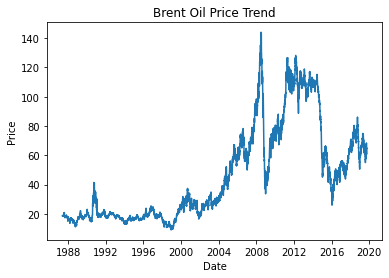

In [6]:
g = sns.lineplot(x='Date',y='Price',data = df)
plt.title("Brent Oil Price Trend")

In [7]:
# Function to plot Oil Price Trend between specific period

def plot_price_trend(df, start_date, end_date):
    """
    This function filters the dataframe for the specified date range and 
    plots the line plot of the data using seaborn.
    
    The dataframe may not be indexed on any Datetime column.
    In this case, we use mask to filter out the date.
    
    PS - There is another function provided later in the notebook 
    which used indexed column to filter data
    """
    mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
    sdf = df.loc[mask]
    plt.figure(figsize = (10,5))
    chart = sns.lineplot(x='Date',y='Price',data = sdf)
    plt.title("Brent Oil Price Trend")

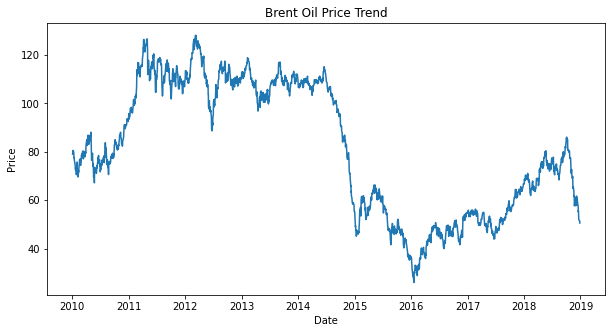

In [8]:
# Test our function

plot_price_trend(df,'2010-01-01','2019-01-01')

# 2. Forecast Model Using Prophet

It uses a decomposable time series model with 3 main components. That are combinided in the equation below:
1. Trend
2. Seasonality
3. Holidays 

![](https://i.imgur.com/23n6ySw.jpg)

**g(t):** piecewise linear or logistic growth curve for modelling non-periodic changes in time series.

**s(t):** periodic changes (e.g. weekly/yearly seasonality).

**h(t):** effects of holidays (user provided) with irregular schedules
εt: error term accounts for any unusual changes not accommodated by the model

Go to the official Prophet Documentation on Facebook to learn more - https://facebook.github.io/prophet/docs/quick_start.html

**Step 1** - First we import the Prophet class from fbprophet module and then create an instance of this.

In [9]:
from fbprophet import Prophet

m = Prophet()

**Step 2** - Note that Prophet requires the date column as 'ds' and outcome varible as 'y'. So we change this in our dataframe and check its data

In [10]:
pro_df = df
pro_df.columns = ['ds','y']
pro_df

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
8211,2019-09-24,64.13
8212,2019-09-25,62.41
8213,2019-09-26,62.08
8214,2019-09-27,62.48


**Step 3** - Next we fit this dataframe into the model object created and then create a forecast for the Oil Price for the next 90 days.

This takes around 10-15 seconds

In [11]:
# each period by default with Prophet is 1 day, however we can set freq to other time intervals
predict_future_days = 240

# We fit the model to our data
m.fit(pro_df)

# Get the future dates we wish to predict 
future = m.make_future_dataframe(periods = predict_future_days, freq = "D")

# Get future predictions 
forecast = m.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Saving Models and Forecasted Predictions

In [12]:
import pickle

with open("prophet_model.pkl", "wb") as f:
    # Pickle the 'Prophet' model 
    pickle.dump(m, f)

# save the Prediction dataframe
forecast.to_pickle("forecast.pkl")

# 3. What did our model create?

In [13]:
df

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
8211,2019-09-24,64.13
8212,2019-09-25,62.41
8213,2019-09-26,62.08
8214,2019-09-27,62.48


In [14]:
# Future is just a dataframe or series of dates in the future
future

,ds
0,1987-05-20
1,1987-05-21
2,1987-05-22
3,1987-05-25
4,1987-05-26
...,...
8451,2020-05-23
8452,2020-05-24
8453,2020-05-25
8454,2020-05-26


**Step 4** - Inspect the forecast data, it has several components:
- trend
- weekly and yearly seasonality 
- and for each of these components, we have the lower and upper confidence intervals data.

In [15]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8451,2020-05-23,40.085560,26.957771,57.424931,39.137990,41.122253,2.520207,2.520207,2.520207,1.047972,1.047972,1.047972,1.472235,1.472235,1.472235,0.0,0.0,0.0,42.605767
8452,2020-05-24,40.063937,26.767979,57.725144,39.087974,41.118192,2.521339,2.521339,2.521339,1.047972,1.047972,1.047972,1.473367,1.473367,1.473367,0.0,0.0,0.0,42.585275
8453,2020-05-25,40.042313,25.513661,55.815780,39.052963,41.106408,1.087381,1.087381,1.087381,-0.384422,-0.384422,-0.384422,1.471803,1.471803,1.471803,0.0,0.0,0.0,41.129694
8454,2020-05-26,40.020690,26.182761,55.468950,39.019601,41.094625,0.971252,0.971252,0.971252,-0.496192,-0.496192,-0.496192,1.467445,1.467445,1.467445,0.0,0.0,0.0,40.991942
8455,2020-05-27,39.999067,24.179942,56.343789,38.987164,41.110876,0.980513,0.980513,0.980513,-0.479724,-0.479724,-0.479724,1.460237,1.460237,1.460237,0.0,0.0,0.0,40.979580


**Step 5** - You can view the plots of these components of the forecast fit model.

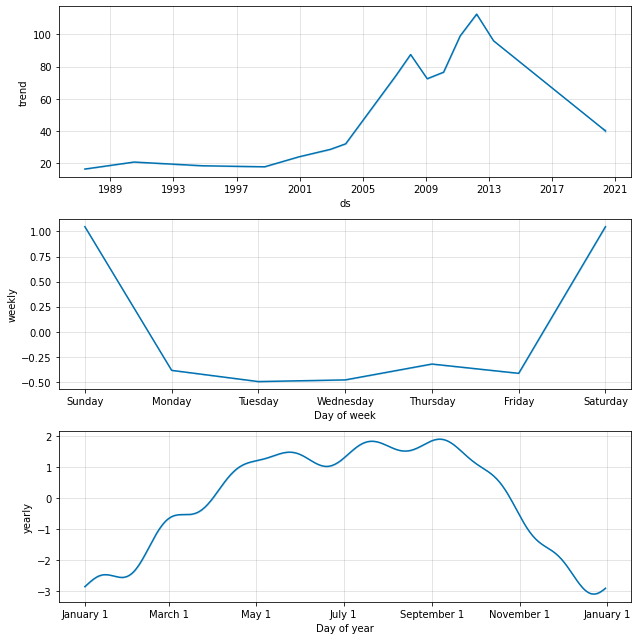

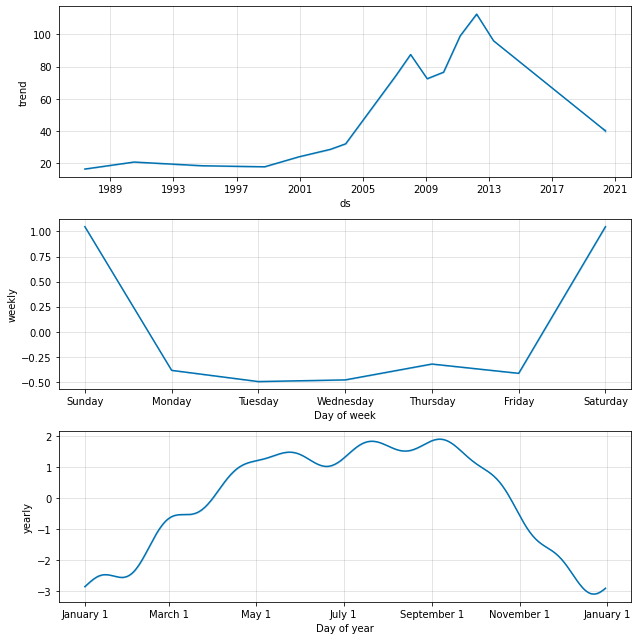

In [16]:
m.plot_components(forecast)

# These are the yearly trend, monthly trend and weekly trend.

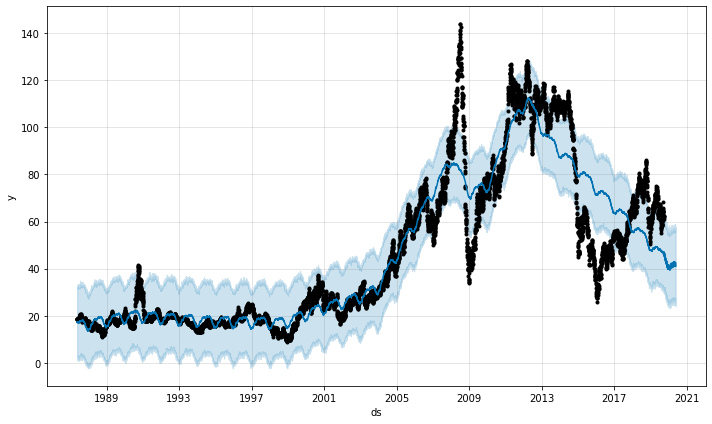

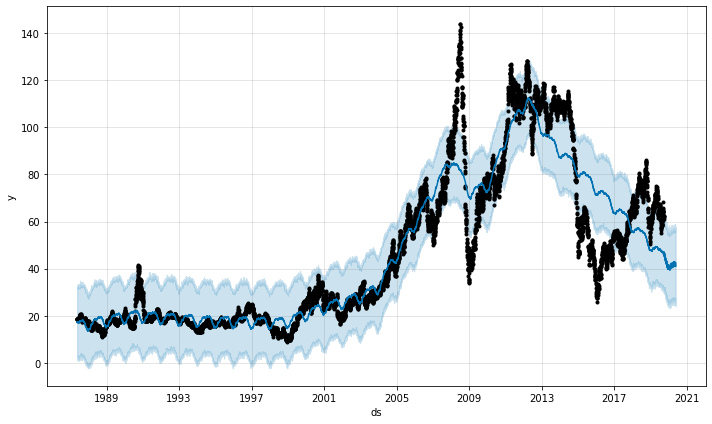

In [17]:
m.plot(forecast)

**Step 6** - Next we want to visualize side by side the original data and the forecast data. So for this, we join the original and forecast data on the column 'ds'

In [18]:
cmp_df = forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']].join(pro_df.set_index('ds'))
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
1987-05-20,17.229343,1.178400,33.156417,18.63
1987-05-21,17.401093,1.580757,31.828641,18.45
1987-05-22,17.320118,2.295245,32.447276,18.55
1987-05-25,17.370411,3.440998,32.701135,18.60
1987-05-26,17.260261,1.997412,32.866436,18.63


In [19]:
cmp_df.tail(5)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-05-23,42.605767,26.957771,57.424931,NaN
2020-05-24,42.585275,26.767979,57.725144,NaN
2020-05-25,41.129694,25.513661,55.815780,NaN
2020-05-26,40.991942,26.182761,55.468950,NaN
2020-05-27,40.979580,24.179942,56.343789,NaN


Note that the original y data is NaN towards the end because, these are the predicted dates.

Step 7 - Then, we visualize the original and forecast data alongside each other

In [20]:
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
1987-05-20,17.229343,1.178400,33.156417,18.63
1987-05-21,17.401093,1.580757,31.828641,18.45
1987-05-22,17.320118,2.295245,32.447276,18.55
1987-05-25,17.370411,3.440998,32.701135,18.60
1987-05-26,17.260261,1.997412,32.866436,18.63


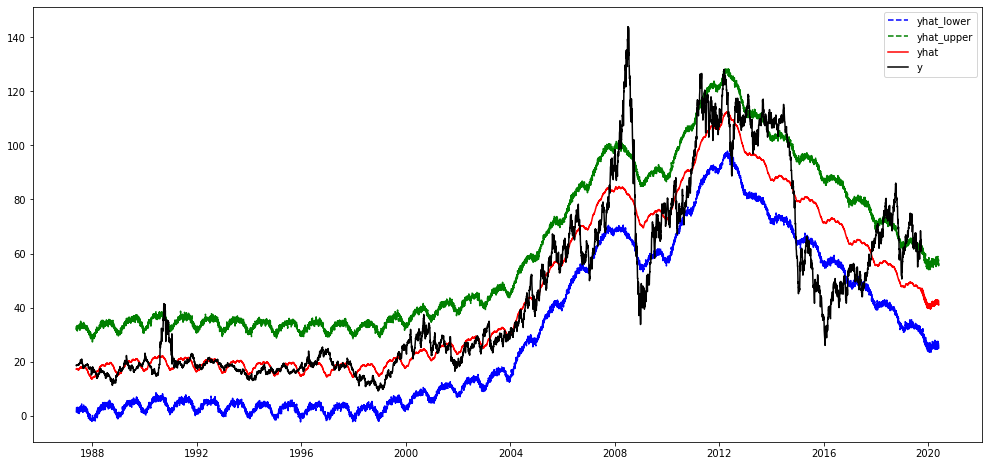

In [21]:
plt.figure(figsize=(17,8))
plt.plot(cmp_df['yhat_lower'], "b--", label = 'yhat_lower')
plt.plot(cmp_df['yhat_upper'], "g--",label = 'yhat_upper')
plt.plot(cmp_df['yhat'], "red", label = 'yhat')
plt.plot(cmp_df['y'], "black", label = 'y')
plt.legend()
plt.show()

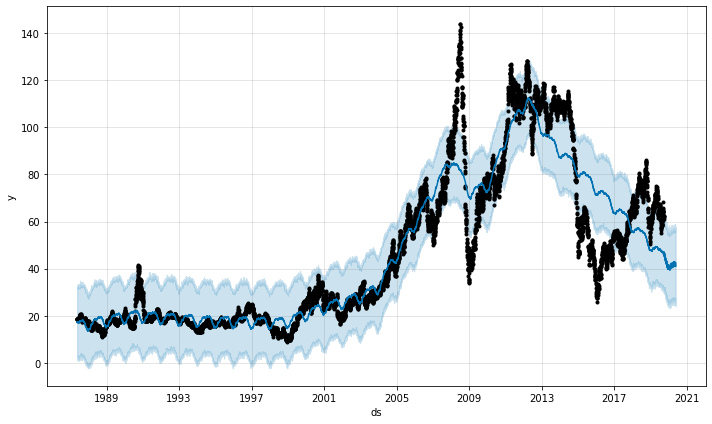

In [22]:
# Or using Prophet's built in plotting tool it's hard to see the forecasted data
fig = m.plot(forecast)

And we can even use Plotly

In [23]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

Step 8 - From above graphes, we still aren't able to readily see the future forecast.

We'll make a function which will show us the original and forecast data between a specified date range.

In [24]:
def plot_price_forecast(df,start_date, end_date):
    """
    This function filters the dataframe for the specified date range and 
    plots the actual and forecast data.
    
    Assumption: 
    - The dataframe has to be indexed on a Datetime column
    This makes the filtering very easy in pandas using df.loc
    """
    cmp_df = df.loc[start_date:end_date]
    plt.figure(figsize=(17,8))
    plt.plot(cmp_df['yhat'])
    plt.plot(cmp_df['y'])
    plt.legend()
    plt.show()

Stpe 9 - Using this function, we can see that, the original graph (orange) does not have data towards the end. This data can be taken from the forecasted graph (blue).

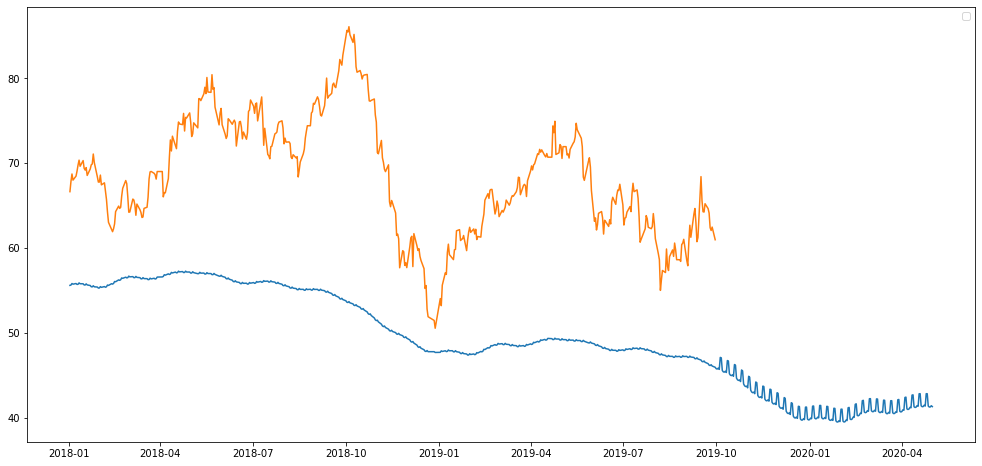

In [25]:
plot_price_forecast(cmp_df,'2018-01-01','2020-05-01')